In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from icecream import ic

In [2]:
# Data import and cleaning
file_time_a = '../Time Development/Data/time_a.csv'
file_time_b_decay = '../Time Development/Data/time_b_decay.csv'
file_time_b_normal = '../Time Development/Data/time_b_normal.csv'
file_time_b_growth = '../Time Development/Data/time_b_growth.csv'

time_a_df = pd.read_csv(file_time_a)
time_b_decay_df = pd.read_csv(file_time_b_decay)
time_b_normal_df = pd.read_csv(file_time_b_normal)
time_b_growth_df = pd.read_csv(file_time_b_growth)

for df in [time_a_df, time_b_decay_df, time_b_normal_df, time_b_growth_df]:
    if "Unnamed: 0" in df.columns:
        df.drop(columns=["Unnamed: 0"], inplace=True)
    df["Date"] = pd.to_datetime(df["Date"])

In [3]:
# Only care about engagement not CTR
features = ["Engagement"]

In [ ]:
def detect_ks_changes(time_a_df, time_b_df, scenario_name, feature, window=14, p_thresh=0.01):
    combined_df = pd.concat([time_a_df, time_b_df], ignore_index=True).sort_values("Date")
    daily_avg = combined_df.groupby("Date")[feature].mean()
    values = daily_avg.values
    dates = daily_avg.index
    launch_date = time_a_df["Date"].iloc[-1]

    change_dates = []

    for i in range(window, len(values) - window):
        pre = values[i - window:i]
        post = values[i:i + window]
        stat, p = ks_2samp(pre, post, method='asymp')
        if p < p_thresh:
            change_dates.append(dates[i])

    # --- Evaluation ---
    cps_before = [d for d in change_dates if d < launch_date]
    cps_after = [d for d in change_dates if d > launch_date]
    detected_before = len(cps_before) > 0
    detected_after = len(cps_after) > 0

    if "Normal" in scenario_name:
        TP = 0
        FP = len(cps_before) + len(cps_after)
        FN = 0
        TN = int(not detected_before and not detected_after)
    else:
        TP = int(detected_after)
        FP = len(cps_before)
        FN = int(not detected_after)
        TN = 0

    if TP + FP == 0 and TP + FN == 0:
        precision = recall = f1 = "N/A"
    else:
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # --- Plot ---
    daily_avg_a = daily_avg[daily_avg.index <= launch_date]
    daily_avg_b = daily_avg[daily_avg.index > launch_date]

    plt.figure(figsize=(10, 5))
    plt.plot(daily_avg_a.index, daily_avg_a.values, label="Time A (Daily Avg)", color="cadetblue")
    plt.plot(daily_avg_b.index, daily_avg_b.values, label="Time B (Daily Avg)", color="mediumslateblue")

    first_detected = None
    for cp in change_dates:
        color = "green" if (cp > launch_date and first_detected is None) else "orange"
        if color == "green":
            first_detected = cp
        plt.axvline(x=cp, color=color, linestyle="--", alpha=0.9, label="Change Point")

    plt.axvline(x=launch_date, color="red", linestyle="--", label="Product Launch")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.title(f"{feature} - Kolmogorov Smirnov Change Detection ({scenario_name})")
    plt.xlabel("Date")
    plt.ylabel(feature)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "Time B Type": scenario_name.split(" ")[0],
        "Scenario": scenario_name,
        "Feature": feature,
        "Launch Date": launch_date.date(),
        "Change Points": [d.date() for d in change_dates],
        "Days After Launch": [(d - launch_date).days for d in change_dates],
        "Count": len(change_dates),
        "TP": TP, "FP": FP, "FN": FN, "TN": TN,
        "Precision": precision if isinstance(precision, str) else round(precision, 2),
        "Recall": recall if isinstance(recall, str) else round(recall, 2),
        "F1 Score": f1 if isinstance(f1, str) else round(f1, 2)
    }

c:\Users\krist\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


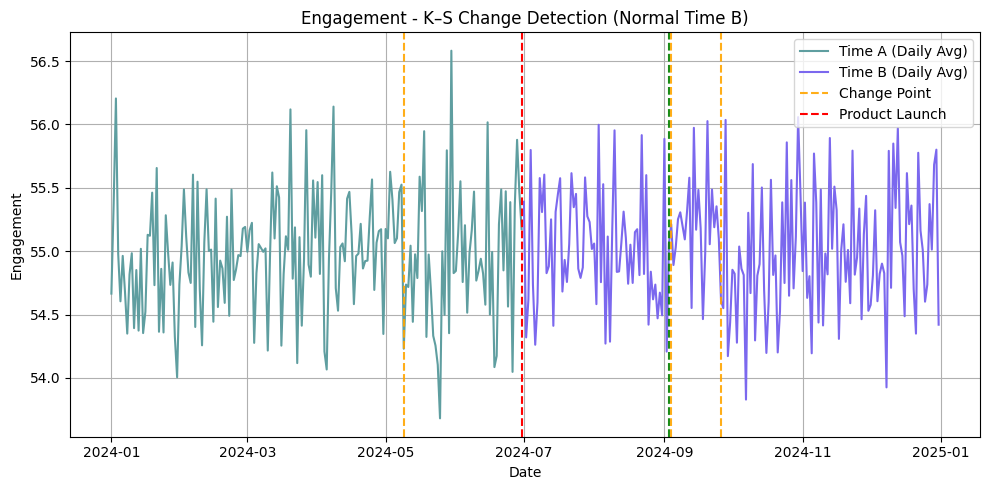

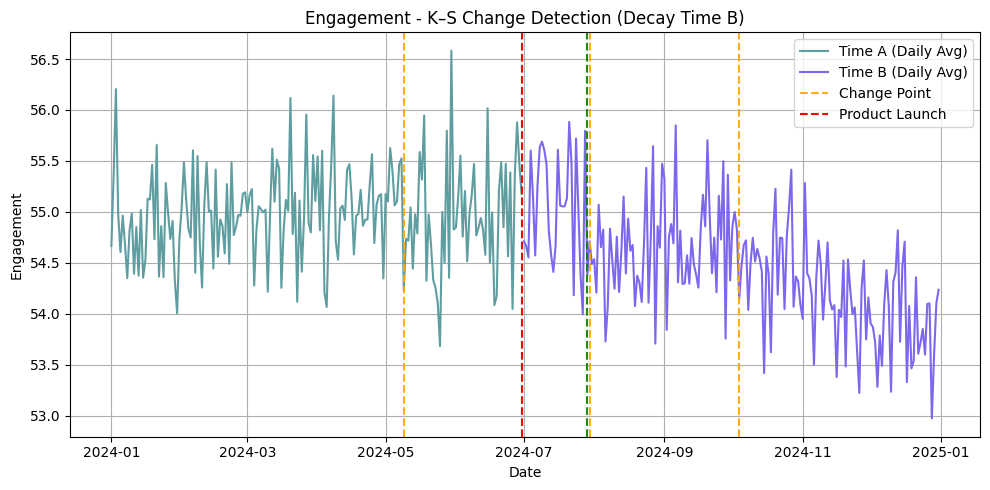

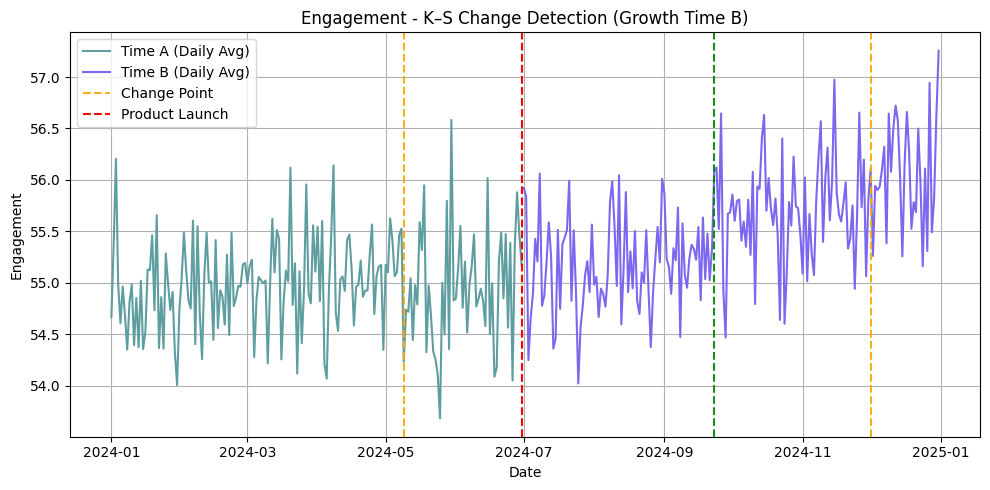


=== K–S Change Point Detection Summary ===
  Time B Type       Scenario     Feature Launch Date  \
0      Normal  Normal Time B  Engagement  2024-06-30   
1       Decay   Decay Time B  Engagement  2024-06-30   
2      Growth  Growth Time B  Engagement  2024-06-30   

                                      Change Points  Days After Launch  Count  \
0  [2024-05-09, 2024-09-03, 2024-09-04, 2024-09-26]  [-52, 65, 66, 88]      4   
1  [2024-05-09, 2024-07-29, 2024-07-30, 2024-10-04]  [-52, 29, 30, 96]      4   
2              [2024-05-09, 2024-09-23, 2024-12-01]     [-52, 85, 154]      3   

   TP  FP  FN  TN  Precision  Recall  F1 Score  
0   0   4   0   0        0.0     0.0      0.00  
1   1   1   0   0        0.5     1.0      0.67  
2   1   1   0   0        0.5     1.0      0.67  


In [5]:
summary_rows = []

scenarios = {
    "Normal Time B": time_b_normal_df,
    "Decay Time B": time_b_decay_df,
    "Growth Time B": time_b_growth_df
}

for scenario_name, time_b_df in scenarios.items():
    for feature in features:
        row = detect_ks_changes(time_a_df, time_b_df, scenario_name, feature, window=14, p_thresh=0.01)
        summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows)
print("\n=== K–S Change Point Detection Summary ===")
print(summary_df)
